**Human Language Technologies Project**

**Authors:** Dalla Noce Niko, Ristori Alessandro

# **HLT Project**

This work is higly based on the tensorflow tutorial https://www.tensorflow.org/text/tutorials/transformer, our aim was to introduce BERT as an encoder in the model and try combinations with different architectures (both RNNs and transformers).

## **Setup**
We need to install the transformers package to use the models and tokenizers from HuggingFace.

In [9]:
!pip install transformers

In [10]:
import logging
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

The model training is going to run on TPUs since they are the optimized for working with tensors, if there are no TPUs avilable then we work with a GPU instead.

In [11]:
# Detect hardware
try:
    tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu_resolver = None
    gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
    tf.config.experimental_connect_to_cluster(tpu_resolver)
    tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
    strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
    print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on single GPU ', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.10.40.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.10.40.90:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  ['10.10.40.90:8470']
Number of accelerators:  8


In [12]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

In [13]:
!git clone "https://github.com/nikodallanoce/HLT/"  # clone the project repository

fatal: destination path 'HLT' already exists and is not an empty directory.


## **Building the training, validation and test set**

We need to build our three sets by preprocessing the en-it anki dataset, tokenizing it and splitting it into training, validation and test.

### **Preprocessing the dataset**

Create two lists containing the sentences of the anki dataset, one in english and one in italian.

Let's define the method to preprocess the anki dataset.

In [14]:
def create_dataset_anki(name: str, preprocessed:bool) -> (list, list):
    with open(name, encoding="UTF-8") as datafile:
        src_set = list()
        dst_set = list()
        for sentence in datafile:
            sentence = sentence.split("\t")
            src_set.append(sentence[0])
            if preprocessed:
                dst_set.append(sentence[1].split("\n")[0])
            else:
                dst_set.append(sentence[1])

    return src_set, dst_set

The dataset is in the project repository inside a zip file, we need to extract it and then we can build our lists using the previous method.

In [15]:
import zipfile
with zipfile.ZipFile("HLT/dataset/dataset_anki_it.zip", 'r') as zip_ref:
    zip_ref.extractall("")

en_set, it_set = create_dataset_anki("ita_preprocessed.txt", True)
print("The corpus' size is: {0}".format(len(en_set)))

The corpus' size is: 352040


### **Dataset tokenization**

We tokenize each sentence in the two lists by using the tokenizers from huggingface.

Before we create the dataset from our lists, we have to tokenize each sentence from the corpus by using the BERT tokenizer for english and the one for italian. Moreover we can get the number of tokens for both source and target.

In [16]:
eng_src = "t5-base"
ita_src = "dbmdz/bert-base-italian-cased"

In [17]:
from transformers import BertTokenizer, BertTokenizerFast, TFMT5EncoderModel, T5TokenizerFast, AutoTokenizer, XLMTokenizer, TFT5EncoderModel, DistilBertTokenizerFast, TFDistilBertModel

logging.getLogger("transformers").setLevel(logging.ERROR)  # suppress warning for transformers

# Create the tokenizers and get the number of tokens
tokenizer_en = T5TokenizerFast.from_pretrained(eng_src)
tokenizer_it = BertTokenizerFast.from_pretrained(ita_src)
v_size_en = tokenizer_en.vocab_size
v_size_it = tokenizer_it.vocab_size

print("Number of tokens for the english dataset: {0}".format(v_size_en))
print("Number of tokens for the italian dataset: {0}".format(v_size_it))

Number of tokens for the english dataset: 32100
Number of tokens for the italian dataset: 31102


Let's calculate the max number of tokens allowed, this number is taken such that 99% of the sentences in the dataset are fully tokenized.

In [18]:
def set_max_tokens(dataset: list, language: str = "en") -> int:
    len_sentences = [len(sentence.split()) for sentence in dataset]
    mean_len_sentences = np.mean(len_sentences)
    print("{0} dataset average sentence length: {1}".format(language, mean_len_sentences))
    max_length = int(mean_len_sentences + 3 * np.std(len_sentences))
    print("{0} dataset max length allowed: {1}".format(language, max_length))
    return max_length

max_length_en = set_max_tokens(en_set, "en")
max_length_it = set_max_tokens(it_set, "it")

en dataset average sentence length: 5.492988603988604
en dataset max length allowed: 11
it dataset average sentence length: 5.35585754985755
it dataset max length allowed: 11


Tokenize the source and target dataset.

In [19]:
# Tokenize the dataset
max_length = np.max([max_length_en, max_length_it]) * 2  # use just one of the max length allowed
with strategy.scope():
    tokens_en = tokenizer_en(en_set, add_special_tokens=True,
                              truncation=True, padding="max_length", return_attention_mask=True,
                              return_tensors="tf", max_length=max_length).data["input_ids"]
    tokens_it = tokenizer_it(it_set, add_special_tokens=True,
                              truncation=True, padding="max_length", return_attention_mask=True,
                              return_tensors="tf", max_length=max_length+1).data["input_ids"]

Let's show some sentences from both languages and how they were tokenized.

In [20]:
for _ in range(3):
  i = np.random.randint(len(tokens_en))
  print("En sentence: {0}\nTokenized sentence: {1}".format(en_set[i], tokens_en[i]))
  print("It sentence: {0}\nTokenized sentence: {1}\n".format(it_set[i], tokens_it[i]))

En sentence: Does Tom know what he's doing?
Tokenized sentence: [3520 3059  214  125    3   88   31    7  692   58    1    0    0    0
    0    0    0    0    0    0    0    0]
It sentence: Tom sa quello che sta facendo?
Tokenized sentence: [ 102 4024  352  678  158  244 1827 3098  103    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]

En sentence: I'm not as expert as you are.
Tokenized sentence: [  27   31   51   59   38 2205   38   25   33    5    1    0    0    0
    0    0    0    0    0    0    0    0]
It sentence: Non sono esperto come te.
Tokenized sentence: [  102   313   288 11241   342   294   697   103     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0]

En sentence: Tom is keeping his promise.
Tokenized sentence: [3059   19 2627  112 5712    5    1    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
It sentence: Tom sta mantenendo la sua promessa.
Tokenized sentence: [  102  4024   244 1

### **Splitting the dataset**

Then we build the tf dataset and split it into training, validation and test sets.

In [21]:
def split_set(dataset: tf.data.Dataset,
              tr: float = 0.8,
              val: float = 0.1,
              ts: float = 0.1,
              shuffle: bool = True) -> (tf.data.Dataset, tf.data.Dataset, tf.data.Dataset):
    if tr+val+ts != 1:
        raise ValueError("Train, validation and test partition not allowed with such splits")

    dataset_size = dataset.cardinality().numpy()
    if shuffle:
        dataset = dataset.shuffle(dataset_size)

    tr_size = int(tr * dataset_size)
    val_size = int(val * dataset_size)

    tr_set = dataset.take(tr_size)
    val_set = dataset.skip(tr_size).take(val_size)
    ts_set = dataset.skip(tr_size).skip(val_size)
    return tr_set, val_set, ts_set

In [22]:
# Build the dataset and split it in train, validation and test
dataset = tf.data.Dataset.from_tensor_slices((tokens_en, tokens_it))  # build the tf dataset
tr_set, val_set, ts_set = split_set(dataset, 0.8, 0.1, 0.1)  # split the tf dataset
print("Training set size: {0}".format(len(tr_set)))
print("Validation set size: {0}".format(len(val_set)))
print("Test set size: {0}".format(len(ts_set)))

Training set size: 281632
Validation set size: 35204
Test set size: 35204


### **Create training and validation batches**

After we have built our development and test set, we need to split the first one (both training and validation) in batches.


In [23]:
def format_dataset(eng, ita):
    return ({"encoder_inputs": eng, "decoder_inputs": ita[:, :-1],}, ita[:, 1:])

def make_batches(dataset_src_dst: tf.data.Dataset, batch_size: int) -> tf.data.Dataset:
    dataset = dataset_src_dst.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.prefetch(tf.data.experimental.AUTOTUNE).cache()

In [24]:
batch_size =  16 * strategy.num_replicas_in_sync

with strategy.scope():
    tr_batches = make_batches(tr_set, batch_size)
    val_batches = make_batches(val_set, batch_size)

In [25]:
for src, dst in tr_batches.take(1):
    print("encoder inputs shape: {0}".format(src["encoder_inputs"].shape))
    print("decoder inputs shape: {0}".format(src["decoder_inputs"].shape))
    print("targets shape: {0}".format(dst.shape))

encoder inputs shape: (128, 22)
decoder inputs shape: (128, 22)
targets shape: (128, 22)


## **Layers**

Our sequence-to-sequence Transformer consists of a `TransformerEncoder`
and a `TransformerDecoder` chained together.

### **Positional embeddings layer**

To make the model aware of word order, we also use a PositionalEmbedding layer.

In [26]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, v_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=v_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.v_size = v_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

### **Encoder**

The source sequence will be pass to the TransformerEncoder, which will produce a new representation of it. This new representation will then be passed to the TransformerDecoder, together with the target sequence so far (target words 0 to N). 

The single layer of the encoder transformer.

In [27]:
class EncoderLayer(layers.Layer):

    def __init__(self, layers_size: int, dense_size: int, num_heads: int, dropout=0.1, **kwargs) -> None:
        super(EncoderLayer, self).__init__(**kwargs)
        
        self.layers_size = layers_size
        self.dense_size = dense_size
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(num_heads, layers_size)
        self.dense_proj = tf.keras.Sequential(
            [layers.Dense(dense_size, activation="relu"), layers.Dense(layers_size)]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dropout_1 = layers.Dropout(dropout)
        self.dropout_2 = layers.Dropout(dropout)
        self.supports_masking = True

    def call(self, inputs: tf.Tensor, mask=None) -> tf.Tensor:
        if mask is not None:  
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        else:
            print("Mask not built")
            assert False
        
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        attention_output = self.dropout_1(attention_output)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        proj_output = self.dropout_1(proj_output)
        return self.layernorm_2(proj_input + proj_output)

The encoder transformer.

In [28]:
class EncoderTransformer(layers.Layer):

    def __init__(self,
                 num_layers: int,
                 layers_size: int,
                 dense_size: int,
                 num_heads: int,
                 max_length: int,
                 v_size_src: int,
                 dropout: float = 0.1) -> None:
        super(EncoderTransformer, self).__init__()

        self.layers_size = layers_size
        self.num_layers = num_layers
        self.pos_embedding = PositionalEmbedding(max_length, v_size_src, layers_size)
        self.enc_layers = [EncoderLayer(layers_size, dense_size, num_heads) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.supports_masking = True

    def call(self, inputs: tf.Tensor, mask=None) -> tf.Tensor:
        src_embeddings = self.pos_embedding(inputs)
        enc_out = self.dropout(src_embeddings)
        for i in range(self.num_layers):
            enc_out = self.enc_layers[i](enc_out)

        return enc_out  # (batch_size, input_seq_len, layers_size)

### **Decoder**

The `TransformerDecoder` will then seek to predict the next words in the target sequence (N+1 and beyond).

The single layer of the decoder transformer.

In [29]:
class DecoderLayer(layers.Layer):

    def __init__(self, layers_size: int, dense_size: int, num_heads: int, dropout=0.1, **kwargs) -> None:
        super(DecoderLayer, self).__init__(**kwargs)
        
        self.layers_size = layers_size
        self.dense_size = dense_size
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads, layers_size)
        self.attention_2 = layers.MultiHeadAttention(num_heads, layers_size)
        self.dense_proj = tf.keras.Sequential(
            [layers.Dense(dense_size, activation="relu"), layers.Dense(layers_size)]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.dropout_1 = layers.Dropout(dropout)
        self.dropout_2 = layers.Dropout(dropout)
        self.dropout_3 = layers.Dropout(dropout)
        self.supports_masking = True

    def call(self, inputs: tf.Tensor, encoder_outputs: tf.Tensor, mask=None) -> tf.Tensor:
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        attention_output_1 = self.dropout_1(attention_output_1)
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.dropout_2(attention_output_2)
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        proj_output = self.dropout_3(proj_output)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

The decoder transformer.

In [30]:
class DecoderTransformer(layers.Layer):

    def __init__(self,
                 num_layers: int,
                 layers_size: int,
                 dense_size: int,
                 num_heads: int,
                 max_length: int,
                 v_size_dst: int,
                 dropout=0.1) -> None:
        super(DecoderTransformer, self).__init__()

        self.layers_size = layers_size
        self.num_layers = num_layers
        self.pos_embedding = PositionalEmbedding(max_length, v_size_dst, layers_size)
        self.dec_layers = [DecoderLayer(layers_size, dense_size, num_heads) for _ in range(num_layers)]
        self.dropout = layers.Dropout(dropout)
        self.supports_masking = True

    def call(self, inputs: tf.Tensor, enc_output: tf.Tensor, mask=None) -> tf.Tensor:
        dst_embeddings = self.pos_embedding(inputs)
        dec_output = self.dropout(dst_embeddings)
        for i in range(self.num_layers):
            dec_output = self.dec_layers[i](dec_output, enc_output)

        return dec_output

## **Building the model**

Next, we assemble the end-to-end model.

In [31]:
with strategy.scope():
  encoder = TFT5EncoderModel.from_pretrained(eng_src)

In [32]:
def create_model(layers_size: int, num_layers: int, dense_size: int, num_heads: int, max_length: int, encoder=None) -> tf.keras.Model:
    # Encoder
    encoder_inputs = tf.keras.Input(shape=(None,), dtype="int32", name="encoder_inputs")
    if encoder is not None: 
        outputs = encoder(encoder_inputs)
        encoder_outputs = outputs.last_hidden_state
        layers_size = encoder_outputs.shape[-1]  # the size of the encoder and decoder layers must be the same
    else:
        encoder_outputs = EncoderTransformer(num_layers, layers_size, dense_size, num_heads, max_length, v_size_en)(encoder_inputs)

    # Decoder
    decoder_inputs = tf.keras.Input(shape=(None,), dtype="int32", name="decoder_inputs")
    encoded_seq_inputs = tf.keras.Input(shape=(None, layers_size), name="decoder_state_inputs")
    decoder_outputs = DecoderTransformer(num_layers, layers_size, dense_size, num_heads, max_length, v_size_it)(decoder_inputs, encoded_seq_inputs)
    # decoder_outputs = layers.Dropout(0.4)(decoder_outputs)
    decoder_outputs = layers.Dense(v_size_it, activation="softmax")(decoder_outputs)
    decoder = tf.keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs, name="decoder_transformer")

    # Final model
    decoder_outputs = decoder([decoder_inputs, encoder_outputs])
    transformer = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="transformer")
    return transformer

In [33]:
with strategy.scope():
    opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)
    transformer = create_model(512, 6, 2048, 8)
    transformer.summary()
    transformer.compile(opt, loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 encoder_transformer (EncoderTr  (None, None, 512)   79465472    ['encoder_inputs[0][0]']         
 ansformer)                                                                                       
                                                                                                  
 decoder_transformer (Functiona  (None, None, 31102)  145324414  ['decoder_inputs[0][0]'

## **Training the model**

We'll use accuracy as a quick way to monitor training progress on the validation data.
Note that machine translation typically uses BLEU scores as well as other metrics, rather than accuracy.

In [28]:
with strategy.scope():
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='./translator_base.h5', save_weights_only = True, monitor='val_loss', mode='auto', save_best_only=True)

In [29]:
epochs = 20  # This should be at least 30 for convergence
transformer.fit(tr_batches, epochs=epochs, validation_data = val_batches, callbacks=[model_checkpoint_callback])

Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 22) dtype=int32>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 22) dtype=int32>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 22) dtype=int32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 22) dtype=int32>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 22) dtype=int32>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 22) dtype=int32>]


2201/2201 [==============================] - ETA: 0s - loss: 1.0684 - accuracy: 0.6042

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 22) dtype=int32>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 22) dtype=int32>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 22) dtype=int32>]


2201/2201 [==============================] - 555s 211ms/step - loss: 1.0684 - accuracy: 0.6042 - val_loss: 0.5603 - val_accuracy: 0.7420
Epoch 2/20
2201/2201 [==============================] - 396s 180ms/step - loss: 0.4536 - accuracy: 0.7728 - val_loss: 0.3141 - val_accuracy: 0.8213
Epoch 3/20
2201/2201 [==============================] - 395s 179ms/step - loss: 0.2967 - accuracy: 0.8237 - val_loss: 0.2285 - val_accuracy: 0.8505
Epoch 4/20
2201/2201 [==============================] - 395s 179ms/step - loss: 0.2260 - accuracy: 0.8480 - val_loss: 0.1845 - val_accuracy: 0.8670
Epoch 5/20
2201/2201 [==============================] - 397s 180ms/step - loss: 0.1866 - accuracy: 0.8625 - val_loss: 0.1579 - val_accuracy: 0.8775
Epoch 6/20
2201/2201 [==============================] - 395s 180ms/step - loss: 0.1613 - accuracy: 0.8724 - val_loss: 0.1435 - val_accuracy: 0.8840
Epoch 7/20
2201/2201 [==============================] - 396s 180ms/step - loss: 0.1442 - accuracy: 0.8793 - val_loss: 0.133

KeyboardInterrupt: ignored

In [40]:
ts_loss, ts_accuracy = transformer.evaluate(make_batches(ts_set, batch_size))
print("Test loss: {0}\nTest accuracy: {1}".format(ts_loss, ts_accuracy))

RuntimeError: ignored

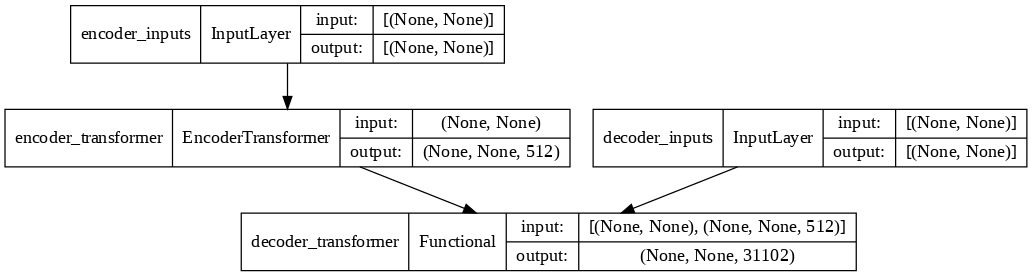

In [30]:
tf.keras.utils.plot_model(
    transformer, to_file='model_base.png', show_shapes=True, dpi=90
)

In [31]:
transformer.save_weights('./translator_base.h5', overwrite=True)

## **Translator**

In [34]:
tokenizer_it = BertTokenizer.from_pretrained(ita_src)
with strategy.scope():
  transformer = create_model(512, 6, 2048, 8)
  transformer.load_weights('./translator_base.h5')

In [42]:
class Translator:

    def __init__(tokenizer_src, tokenizer_dst, max_length: int, transformer: tf.keras.Model) -> None:
        self.tokenizer_src = tokenizer_src
        self.tokenizer_dst = tokenizer_dst
        self.max_length = max_length
        self.transformer = transformer

    def translate(input_sentence: str) -> (list, str):
        tokenized_input_sentence = self.tokenizer_src(input_sentence, return_tensors='tf', add_special_tokens=True,
                                                max_length = self.max_length, padding='max_length', truncation=True).data["input_ids"]
        decoded_sentence = "[CLS]"
        list_tokens=[decoded_sentence]
        for i in range(self.max_length):
            decoded_sentence = self.tokenizer_dst.convert_tokens_to_string(list_tokens)
            tokenized_target_sentence = self.tokenizer_dst(decoded_sentence, return_tensors='tf', add_special_tokens=False,
                                                    max_length = self.max_length, padding='max_length').data['input_ids']
            predictions = self.transformer([tokenized_input_sentence, tokenized_target_sentence])
            sampled_token_index = np.argmax(predictions[0, i, :])
            sampled_token = self.tokenizer_dst.ids_to_tokens[sampled_token_index]
          
            if sampled_token == "[SEP]":
              decoded_sentence = self.tokenizer_dst.convert_tokens_to_string(list_tokens[1:])
              break
            
            list_tokens.append(sampled_token)
        
        return list_tokens, decoded_sentence

In [43]:
en = "My house has several bedrooms."
tokens, translated = decode_sequence(en)
print([en, translated])

['My house has several bedrooms.', 'La mia casa ha diverse camere da letto .']


In [34]:
from transformers import BertTokenizer, BertTokenizerFast, TFBertModel, TFT5EncoderModel, T5TokenizerFast, DistilBertTokenizerFast, TFDistilBertModel

encoder_models = {
    "bert" : {
        "tokenizer" : BertTokenizerFast.from_pretrained("bert-base-cased"),
        "encoder" : TFBertModel.from_pretrained("bert-base-cased"),
    },
    "t5" : {
        "tokenizer" : T5TokenizerFast.from_pretrained("t5-base"),
        "encoder" : TFT5EncoderModel.from_pretrained("t5-base"),
    },
    "distil_bert" : {
        "tokenizer" : DistilBertTokenizerFast.from_pretrained("distilbert-base-cased"),
        "encoder" : TFDistilBertModel.from_pretrained("distilbert-base-cased"),
    },
}